In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_simulation(theta0_deg, alpha0_deg, h0_km, h_obs_km):
    h_obs = h_obs_km * 1e3  # Observer height in meters
    h0 = h0_km * 1e3  # Initial height in meters
    RE = 6371e3  # Earth's radius in meters
    c = 299792458  # Speed of light in m/s
    r0 = RE + h0  # Earth's radius plus initial height
    theta0 = np.radians(theta0_deg)  #incident angle of photon with respect to radial direction to observer
    alpha0 = np.radians(alpha0_deg)  #the angle of the photon with respect to horizontal (spherical coordinates center at observer)
    def straight_line_path_time(x, z0, x0, h_obs, theta0, alpha0, size=100):
        x_strsight = x #(z_strsight - z0) * np.tan((theta0+alpha0-alphaE)) + x0
        z_strsight = (x_strsight - x0)/np.tan((theta0+alpha0-alphaE)) +z0
        r_strsight = np.sqrt(z_strsight**2 + x_strsight**2)
        s_strsight = np.sqrt((z_strsight - z0)**2 + (x_strsight - x0)**2)
        t_strsight = s_strsight / c
        return t_strsight, z_strsight, x_strsight, r_strsight
    def cal_alphaEarth(h0, h_obs, alpha0):
        H0 = RE + h0
        H_obs = RE + h_obs
        A = H0**2 - H_obs**2
        B = -2*H0*H_obs/np.tan(alpha0)
        C = -H0**2*(1+1/np.tan(alpha0)**2)
        delta = B**2 - 4*A*C
        alpha_Earth_1 = np.arcsin(2*A/(-B + np.sqrt(delta)))
        alpha_Earth_2 = np.arcsin(2*A/(-B - np.sqrt(delta)))
        #take the real and positive solution
        if np.isreal(alpha_Earth_1) and alpha_Earth_1 > 0:
            return alpha_Earth_1
        else:
            print(alpha_Earth_1, alpha_Earth_2)
            return alpha_Earth_2
    alphaE = cal_alphaEarth(h0, h_obs, alpha0) # Corrected initial angle in Earth center spherical coordinates
    #print("Corrected initial angle in Earth center spherical coordinates (degrees):", np.degrees(alphaE))
    x0 = r0 * np.sin(alphaE) # Initial x position center at Earth's center
    z0 = r0 * np.cos(alphaE)  # Initial z position center at Earth's center
    H = 7e3  # Scale height in meters
    n0 = 1.0003  # Refractive index at sea level
    step_size = 10 # Step size in meters

    def dz_curve_atms(z,x,r,n,A,dr):
        sin_theta = A/(n*r)
        cos_theta = np.sqrt(1 - sin_theta**2)
        cos_alphaE = z/r
        sin_alphaE = x/r
        cos_theta_plus_alphaE = cos_theta * cos_alphaE - sin_theta * sin_alphaE
        return np.abs(dr * cos_theta_plus_alphaE/cos_theta)

    def dx_curve_atms(z,x,r,n,A,dr):
        sin_theta = A/(n*r)
        cos_theta = np.sqrt(1 - sin_theta**2)
        cos_alphaE = z/r
        sin_alphaE = x/r
        sin_theta_plus_alphaE = sin_theta * cos_alphaE + cos_theta * sin_alphaE
        return np.abs(dr* sin_theta_plus_alphaE/cos_theta)

    def dr_curve_atms(z,x,r,n,A,dx):
        sin_theta = A/(n*r)
        cos_theta = np.sqrt(1 - sin_theta**2)
        cos_alphaE = z/r
        sin_alphaE = x/r
        sin_theta_plus_alphaE = sin_theta * cos_alphaE + cos_theta * sin_alphaE
        return np.abs(dx *cos_theta/sin_theta_plus_alphaE)

    def n(r,H, n0): #refractive index as a function of radius
        return (n0-1)*np.exp(-(r-RE)/H)+1

    def A(r, theta, H, n0): #Bouguer's invariant
        return n(r,H,n0)*r*np.sin(theta)

    def v_group(r,H,n0): #group velocity of light in medium
        return c/n(r,H,n0)

    z_sign = -np.cos(alpha0+theta0)/np.abs(np.cos(alpha0+theta0)) # positve for upward movement, negative for downward movement
    x_sign = -1 # positive for moving away from vertical plane, negative for moving towards vertical plane
    dx = step_size # Step size negative for downward movement
    z_curve = z0
    x_curve = x0
    r_curve = r0
    A0 = A(r0, ((theta0+alpha0)-alphaE), H, n0)
    #print("Check initial value", z_curve, x_curve, r_curve)
    t_curve=0
    X_curve = []
    Z_curve = []
    R_curve = []
    T_curve = []
    X_curve.append(x_curve)
    Z_curve.append(z_curve)
    R_curve.append(r_curve)
    T_curve.append(t_curve)
    for i in range(10000):
        sin_theta = A0/(n(r_curve, H, n0)*r_curve)
        if sin_theta > 1:
            print("Total internal reflection at step", i)
            #Use the last valid values to calculate the reflection
            r_curve = R_curve[-2]
            z_curve = Z_curve[-2]
            x_curve = X_curve[-2]
            z_sign = -1
        dr_val_curve = dr_curve_atms(z_curve, x_curve, r_curve, n(r_curve, H, n0), A0, dx)
        dz_val_curve = z_sign*dz_curve_atms(z_curve, x_curve, r_curve, n(r_curve, H, n0), A0, dr_val_curve)
        dx_val_curve = x_sign*dx_curve_atms(z_curve, x_curve, r_curve, n(r_curve, H, n0), A0, dr_val_curve)
        ds_val_curve = np.sqrt(dz_val_curve**2 + dx_val_curve**2)
        if np.isnan(ds_val_curve / v_group(r_curve, H, n0)):
            print("NaN encountered at step", i)
            break
        t_curve += ds_val_curve / v_group(r_curve, H, n0)
        z_curve += dz_val_curve
        x_curve += dx_val_curve
        r_curve = np.sqrt((z_curve)**2 + x_curve**2)
        #print("Step", i, "angle (degrees):", np.degrees(np.arcsin(dx_val_curve/ds_val_curve)), "dz:", dz_val_curve, "dx:", dx_val_curve, "r:", r_curve-RE)
        #print("Position (z,x,r):", z_curve, x_curve, r_curve, z1,z2,x1,x2)
        #print("Check initial value", np.sqrt(z_curve**2 + x_curve**2)- r_curve)
        alpha_curve = np.arctan(x_curve/z_curve)
        #if (r_curve < RE+h_obs):
            #print("Reached horizontal plane at step", i)
            #print("Position (z,x):", z_curve-RE-h_obs, x_curve)
            #break
        if alpha_curve < 0:
            print("Reach vertical plane at step", i)
            print("Position (z,x):", z_curve-RE-h_obs, x_curve)
            break


        X_curve.append(x_curve)
        Z_curve.append(z_curve)
        R_curve.append(r_curve)
        T_curve.append(t_curve)

    R_curve = np.array(R_curve) - RE
    Z_curve = np.array(Z_curve)
    X_curve = np.array(X_curve)
    T_curve = np.array(T_curve)
    t_straight_line, z_straight_line, x_straight_line, r_straight_line = straight_line_path_time(X_curve,z0, x0, h_obs, theta0, alpha0, size=len(T_curve))
    return (X_curve, Z_curve, R_curve, T_curve, x_straight_line, z_straight_line, r_straight_line,t_straight_line, alphaE)



In [ ]:
# Example usage
theta0_deg = np.linspace(2, 2, 1)  # Incident angle in degrees
alpha0_deg = 80  # Initial angle with respect to horizontal in degrees
h0_km = np.linspace(3, 10, 100) # Initial height in km
h_obs_km = 3  # Observer height in km
DT_curve_list = []
last_R_curve = []
for theta0_i in theta0_deg:
    for h0 in h0_km:
        (X_curve, Z_curve, R_curve, T_curve, x_straight_line, z_straight_line, r_straight_line,t_straight_line, alphaE) = run_simulation(theta0_i, alpha0_deg, h0, h_obs_km)
        delta_t_curve = abs(T_curve[-1]) - abs(t_straight_line[-1])
        DT_curve_list.append(delta_t_curve)
        last_R_curve.append(R_curve[-1]-h_obs_km*1e3)

last_R_curve = np.array(last_R_curve)
RE= 6371e3
plt.plot(X_curve/1e3, (np.array(Z_curve)-RE)/1e3, label='Curved Atmosphere')
plt.plot(x_straight_line/1e3, (z_straight_line-RE)/1e3, label='Straight Line Path', linestyle='--')
plt.xlabel('Horizontal Distance (km)')
plt.ylabel('Height (km)')
plt.title('Photon Trajectory in Curved vs Flat Atmosphere')
plt.legend()
plt.grid()
plt.show()

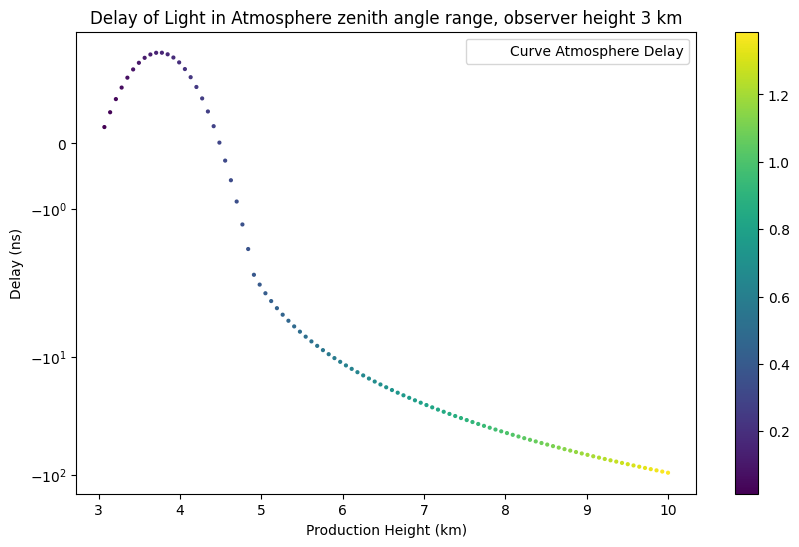

In [67]:
#Run simulation for a range of incident angles and plot the results
plt.figure(figsize=(10, 6))
plt.scatter(h0_km, np.array(DT_curve_list)/1e-9, c = last_R_curve/1e3, label='Curve Atmosphere Delay', s=4)
plt.colorbar()
plt.legend()
plt.xlabel('Production Height (km)')
plt.ylabel('Delay (ns)')
plt.yscale('symlog')
plt.title(f'Delay of Light in Atmosphere zenith angle range, observer height {h_obs_km} km')
plt.show()

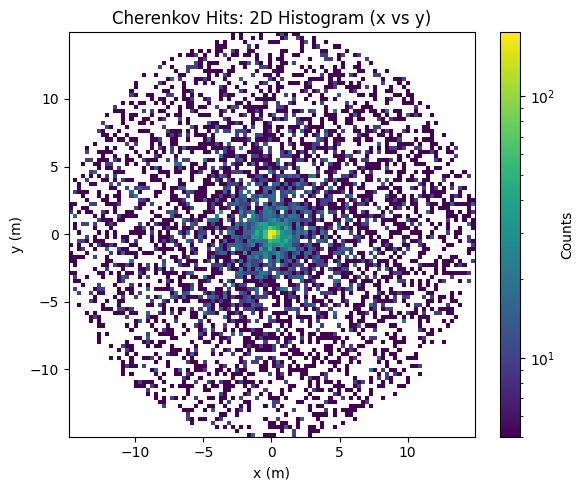

In [43]:
#Cherenkov histogram with curve option
import pandas as pd

# Path to your Cherenkov hits CSV file
csv_path = "/uufs/chpc.utah.edu/common/home/u1520754/corsika8_output/cherenkov_hits.csv"

# Read the CSV into a pandas DataFrame
hits = pd.read_csv(csv_path)

# Your data
import numpy as np
R_E = 6371000  # Earth's radius in meters
w = np.array(hits["wavelength_nm"])
t = np.array(hits["time_ns"])
H = np.array(hits["z_production_m"]) - R_E
x_c = np.array(hits["x_m"])
y_c = np.array(hits["y_m"])
r_c = np.sqrt(x_c**2 + y_c**2)
z_c = np.array(hits["z_m"])
dir_x = np.array(hits["dir_x"])
dir_y = np.array(hits["dir_y"])
dir_z = np.array(hits["dir_z"])
weight = np.array(hits["weight"])  # <-- ADD THIS
n_minus_1 = np.array(hits["n_minus_1"])  # <-- ADD THIS
path = np.array(hits["path_length_m"])  # <-- ADD THIS
dir_ground_x = np.array(hits["dir_ground_x"])
dir_ground_y = np.array(hits["dir_ground_y"])
dir_ground_z = np.array(hits["dir_ground_z"])
emission_angle = np.degrees(np.arccos(-dir_ground_z))
arrival_angle = np.degrees(np.arccos(dir_z))
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# Assuming your DataFrame from the previous cell is called `hits`
# and has columns named "x" and "y"

plt.figure(figsize=(6, 5))

h = plt.hist2d(
    hits["x_m"],
    hits["y_m"],
    bins=100,          # adjust binning as needed
    cmap="viridis",
    #range=[[-15, 15], [-15, 15]],
    #range=[[-5, 5], [-5, 5]],
    weights=hits["weight"],
    norm=LogNorm()  # use logarithmic color scale
)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Cherenkov Hits: 2D Histogram (x vs y)")
plt.colorbar(h[3], label="Counts")
plt.tight_layout()
plt.show()



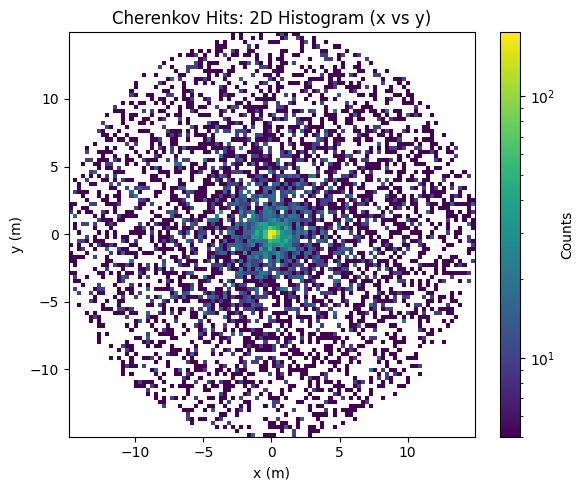

In [39]:
#CHerenkov histogram without curve option
import pandas as pd

# Path to your Cherenkov hits CSV file
csv_path = "/uufs/chpc.utah.edu/common/home/u1520754/corsika8_output_2/cherenkov_hits.csv"

# Read the CSV into a pandas DataFrame
hits = pd.read_csv(csv_path)

# Your data
import numpy as np
R_E = 6371000  # Earth's radius in meters
w2 = np.array(hits["wavelength_nm"])
t2 = np.array(hits["time_ns"])
H2 = np.array(hits["z_production_m"]) - R_E
x_c2 = np.array(hits["x_m"])
y_c2 = np.array(hits["y_m"])
r_c2 = np.sqrt(x_c2**2 + y_c2**2)
z_c2 = np.array(hits["z_m"])
dir_x2 = np.array(hits["dir_x"])
dir_y2 = np.array(hits["dir_y"])
dir_z2 = np.array(hits["dir_z"])
weight2 = np.array(hits["weight"])  # <-- ADD THIS
n_minus_1_2 = np.array(hits["n_minus_1"])  # <-- ADD THIS
path2 = np.array(hits["path_length_m"])  # <-- ADD THIS
dir_ground_x2 = np.array(hits["dir_ground_x"])
dir_ground_y2 = np.array(hits["dir_ground_y"])
dir_ground_z2 = np.array(hits["dir_ground_z"])
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# Assuming your DataFrame from the previous cell is called `hits`
# and has columns named "x" and "y"

plt.figure(figsize=(6, 5))

h2 = plt.hist2d(
    hits["x_m"],
    hits["y_m"],
    bins=100,          # adjust binning as needed
    cmap="viridis",
    #range=[[-15, 15], [-15, 15]],
    #range=[[-5, 5], [-5, 5]],
    weights=hits["weight"],
    norm=LogNorm()  # use logarithmic color scale
)
#plot position of particles on ground
#plt.scatter(x_pos, y_pos, s=20*weight, 
#                    alpha=0.6, cmap='viridis', marker='x', label='Particle Positions')


plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Cherenkov Hits: 2D Histogram (x vs y)")
plt.colorbar(h2[3], label="Counts")
plt.tight_layout()
plt.show()


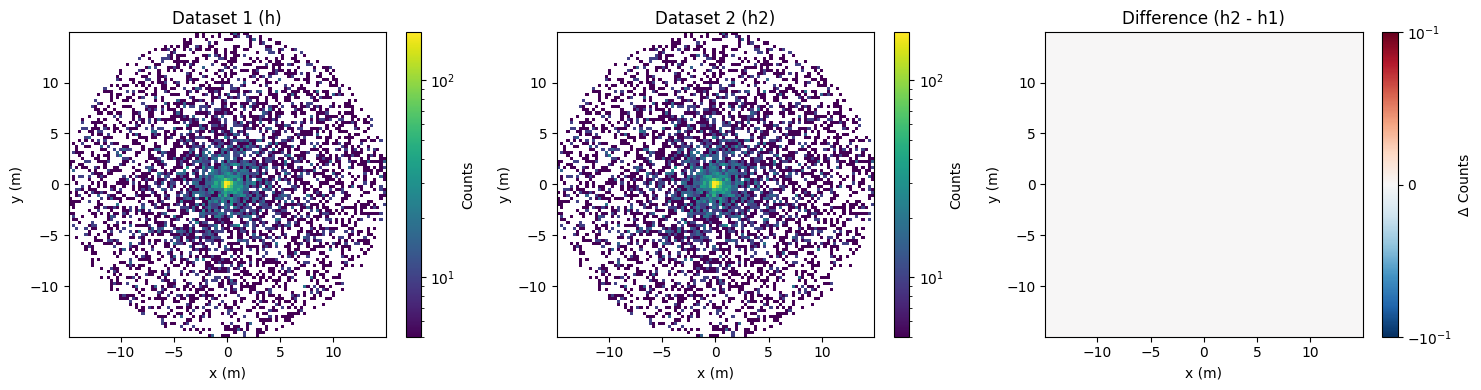

Max difference: 0.00e+00
Min difference: 0.00e+00
Mean difference: 0.00e+00
Total h1: 2.93e+04
Total h2: 2.93e+04


In [40]:
#Comparing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

# Load both datasets
csv_path1 = "/uufs/chpc.utah.edu/common/home/u1520754/corsika8_output/cherenkov_hits.csv"
csv_path2 = "/uufs/chpc.utah.edu/common/home/u1520754/corsika8_output_2/cherenkov_hits.csv"

hits1 = pd.read_csv(csv_path1)
hits2 = pd.read_csv(csv_path2)

# Define common bin edges for both histograms
bins = 100
x_min = min(hits1["x_m"].min(), hits2["x_m"].min())
x_max = max(hits1["x_m"].max(), hits2["x_m"].max())
y_min = min(hits1["y_m"].min(), hits2["y_m"].min())
y_max = max(hits1["y_m"].max(), hits2["y_m"].max())

# Create histograms with same bins using np.histogram2d
h1_counts, x_edges, y_edges = np.histogram2d(
    hits1["x_m"], hits1["y_m"],
    bins=bins,
    range=[[x_min, x_max], [y_min, y_max]],
    weights=hits1["weight"]
)

h2_counts, _, _ = np.histogram2d(
    hits2["x_m"], hits2["y_m"],
    bins=bins,
    range=[[x_min, x_max], [y_min, y_max]],
    weights=hits2["weight"]
)

# Calculate difference
diff = h2_counts - h1_counts

# Plot the difference
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot h1
im1 = axes[0].pcolormesh(x_edges, y_edges, h1_counts.T, cmap="viridis", norm=LogNorm())
axes[0].set_xlabel("x (m)")
axes[0].set_ylabel("y (m)")
axes[0].set_title("Dataset 1 (h)")
plt.colorbar(im1, ax=axes[0], label="Counts")

# Plot h2
im2 = axes[1].pcolormesh(x_edges, y_edges, h2_counts.T, cmap="viridis", norm=LogNorm())
axes[1].set_xlabel("x (m)")
axes[1].set_ylabel("y (m)")
axes[1].set_title("Dataset 2 (h2)")
plt.colorbar(im2, ax=axes[1], label="Counts")

# Plot difference (h2 - h1)
# Use SymLogNorm for difference since it can be positive or negative
vmax = np.abs(diff).max()
if vmax > 0:
    im3 = axes[2].pcolormesh(
        x_edges, y_edges, diff.T,
        cmap="RdBu_r",  # diverging colormap: red=positive, blue=negative
        #vmin=-vmax, vmax=vmax
        norm = SymLogNorm(linthresh=1, vmin=-vmax, vmax=vmax)
    )
else:
    im3 = axes[2].pcolormesh(x_edges, y_edges, diff.T, cmap="RdBu_r", norm = SymLogNorm(linthresh=1, vmin=-vmax, vmax=vmax))
    
axes[2].set_xlabel("x (m)")
axes[2].set_ylabel("y (m)")
axes[2].set_title("Difference (h2 - h1)")
plt.colorbar(im3, ax=axes[2], label="Δ Counts")

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Max difference: {diff.max():.2e}")
print(f"Min difference: {diff.min():.2e}")
print(f"Mean difference: {diff.mean():.2e}")
print(f"Total h1: {h1_counts.sum():.2e}")
print(f"Total h2: {h2_counts.sum():.2e}")


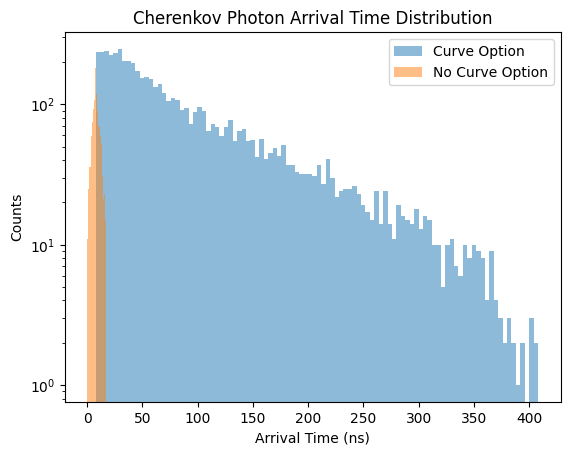

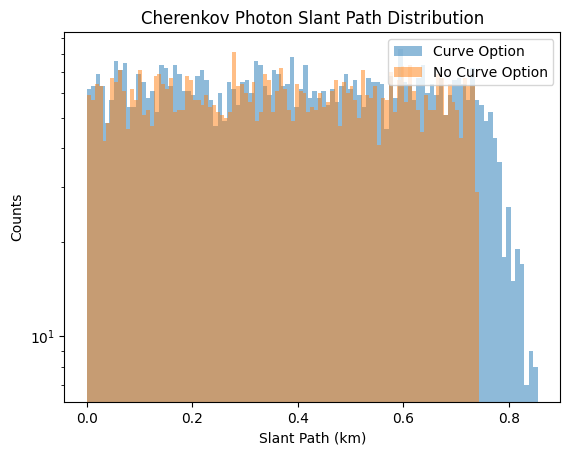

In [41]:
t_min = min(t.min(), t2.min())

#t_bins = np.logspace(-1, np.log10(max((t-t_min).max(), (t2-t_min).max())), 100)
plt.hist((t-t_min), bins=100, alpha=0.5, label='Curve Option')
plt.hist((t2-t_min), bins=100, alpha=0.5, label='No Curve Option')
plt.xlabel('Arrival Time (ns)')
plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Counts')
plt.title('Cherenkov Photon Arrival Time Distribution')
plt.legend()
plt.show()

#path_bins = np.logspace(np.log10(min(path.min(), path2.min())), np.log10(max(path.max(), path2.max())), 100)
plt.hist(path/1e3, bins=100, alpha=0.5, label='Curve Option')
plt.hist(path2/1e3, bins=100, alpha=0.5, label='No Curve Option')
plt.xlabel('Slant Path (km)')
plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Counts')
plt.title('Cherenkov Photon Slant Path Distribution')
plt.legend()
plt.show()

In [ ]:
#Interactive plot
import numpy as np
import plotly.graph_objects as go

X_c = np.array(hits["x_m"])
Y_c = np.array(hits["y_m"])
T = np.array(hits["time_ns"])
weight = np.array(hits["weight"])

# Create time bins with 10 ns steps
time_step = 10.0  # nanoseconds
time_min, time_max = T.min(), T.max()
time_edges = np.arange(time_min, time_max + time_step, time_step)
time_centers = (time_edges[:-1] + time_edges[1:]) / 2
n_time_bins = len(time_edges) - 1

# Create spatial bins
n_spatial_bins = 100
x_edges = np.linspace(X_c.min(), X_c.max(), n_spatial_bins + 1)
y_edges = np.linspace(Y_c.min(), Y_c.max(), n_spatial_bins + 1)

# Pre-compute WEIGHTED 2D histograms for each time slice
histograms = []
valid_indices = []
valid_time_centers = []

for i in range(n_time_bins):
    mask = (T >= time_edges[i]) & (T < time_edges[i + 1])
    n_photons_weighted = np.sum(weight[mask])  # <-- Use weighted sum

    if n_photons_weighted >= 10:
        hist, _, _ = np.histogram2d(
            X_c[mask], 
            Y_c[mask], 
            bins=[x_edges, y_edges],
            weights=weight[mask]  # <-- ADD WEIGHTS
        )
        histograms.append(hist.T)
        valid_indices.append(i)
        valid_time_centers.append(time_centers[i])

# Find global max for consistent color scale
global_max = max(h.max() for h in histograms) if histograms else 1

# Create figure
fig = go.Figure()

for i, hist in enumerate(histograms):
    hist_log = np.log10(hist + 1)

    fig.add_trace(
        go.Heatmap(
            z=hist_log,
            x=(x_edges[:-1] + x_edges[1:]) / 2,
            y=(y_edges[:-1] + y_edges[1:]) / 2,
            colorscale='plasma',
            zmin=0,
            zmax=np.log10(global_max + 1),
            colorbar=dict(
                title='log₁₀(Photon Count)',
                tickmode='array',
                tickvals=np.log10(np.array([1, 10, 100, 1000, 10000]) + 1),
                ticktext=['1', '10', '100', '1k', '10k']
            ),
            visible=(i == 0)
        )
    )

# Create slider steps
steps = []
for i in range(len(histograms)):
    step = dict(
        method="update",
        args=[{"visible": [j == i for j in range(len(histograms))]}],
        label=f"{valid_time_centers[i]:.1f}"
    )
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Time: ", "suffix": " ns"},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title=f"Cherenkov Photon Distribution vs Time (Weighted, 10 ns bins)",
    xaxis_title="X (m)",
    yaxis_title="Y (m)",
    width=800,
    height=700,
)

fig.show()


In [69]:
#Make gif
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LogNorm

# Your data
w = np.array(hits["wavelength_nm"])
t = np.array(hits["time_ns"])
t= t - t.min()  # Normalize time to start from zero
h = np.array(hits["z_production_m"])
x_c = np.array(hits["x_m"])
y_c = np.array(hits["y_m"])
r_c = np.sqrt(x_c**2 + y_c**2)
z_c = np.array(hits["z_m"])
dir_x = np.array(hits["dir_x"])
dir_y = np.array(hits["dir_y"])
dir_z = np.array(hits["dir_z"])
weight = np.array(hits["weight"])
# Create time bins with 10 ns steps
time_step = 10.0  # nanoseconds
time_min, time_max = t.min(), t.max()
time_edges = np.arange(time_min, time_max + time_step, time_step)
time_centers = (time_edges[:-1] + time_edges[1:]) / 2
n_time_bins = len(time_edges) - 1

# Create spatial bins for the 2D histogram
n_spatial_bins = 100
x_edges = np.linspace(x_c.min(), x_c.max(), n_spatial_bins + 1)
y_edges = np.linspace(y_c.min(), y_c.max(), n_spatial_bins + 1)

# Pre-compute WEIGHTED 2D histograms for each time slice
histograms = []
valid_time_centers = []

for i in range(n_time_bins):
    # Select photons in this time window
    mask = (t >= time_edges[i]) & (t < time_edges[i + 1])
    n_photons_weighted = np.sum(weight[mask])  # Use weighted sum

    # Only keep frames with weighted count >= 1
    if n_photons_weighted >= 10:
        # Create 2D histogram with weights
        hist, _, _ = np.histogram2d(
            x_c[mask], 
            y_c[mask], 
            bins=[x_edges, y_edges],
            weights=weight[mask]  # Add weights
        )
        histograms.append(hist.T)  # Transpose for correct orientation
        valid_time_centers.append(time_centers[i])

# Find global max for consistent log color scale
global_max = max(h.max() for h in histograms) if histograms else 1
global_min = 1  # Minimum for log scale

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Initialize the plot with the first histogram
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Create initial heatmap with log scale
im = ax.pcolormesh(x_edges, y_edges, histograms[0] + 1, 
                   cmap='plasma', 
                   norm=LogNorm(vmin=global_min, vmax=global_max + 1),
                   shading='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Weighted Photon Count')
cbar.set_ticks([1, 10, 100, 1000, 10000])
cbar.set_ticklabels(['1', '10', '100', '1k', '10k'])

# Set labels and title
ax.set_xlabel('X (m)', fontsize=12)
ax.set_ylabel('Y (m)', fontsize=12)
title = ax.set_title(f'Time: {valid_time_centers[0]:.1f} ns (10 ns bins)\n'
                     f'Cherenkov Photon Distribution (Weighted, {len(histograms)}/{n_time_bins} frames with ≥1000 photons)', 
                     fontsize=14)

# Animation update function
def update(frame):
    im.set_array((histograms[frame] + 1).ravel())
    title.set_text(f'Time: {valid_time_centers[frame]:.1f} ns (10 ns bins)\n'
                   f'Cherenkov Photon Distribution (Weighted, {len(histograms)}/{n_time_bins} frames with ≥1000 photons)')
    return im, title

# Create animation
anim = FuncAnimation(fig, update, frames=len(histograms), 
                     interval=50, blit=True, repeat=True)

# Save as GIF
writer = PillowWriter(fps=5)
anim.save('cherenkov_animation_10ns_zenith89.9_curve.gif', writer=writer, dpi=100)

plt.close()
print(f"Animation saved with {len(histograms)} frames (10 ns time bins)")


Animation saved with 53 frames (10 ns time bins)
